# EDA gold-слоя Media Intelligence Hub

В этом ноутбуке исследуем **gold-слой** пайплайна проекта Media Intelligence Hub.  
Gold-слой содержит очищенные и семантически обогащенные данные новостей:

- `nlp_text` — текст, используемый для NLP (заголовок или полный текст),
- `summary` — краткое extractive-саммари текста,
- `keywords` — ключевые слова и фразы, извлеченные по TF-IDF,
- простые текстовые фичи (`text_length_chars`, `num_sentences`, `num_keywords`).

Цели ноутбука:

1. Проверить качество получившегося gold-слоя.
2. Посмотреть базовые распределения по текстовым фичам.
3. Разобраться с темами, которые чаще всего встречаются в новостях (через `keywords`).
4. Научиться смотреть на динамику ключевых слов по нескольким дням.

## 1. Импорты и базовые настройки

Подключаем библиотеки, настраиваем режим отображения pandas и задаем пути к проекту и папке с gold-файлами.

In [23]:
# Импорты стандартных и аналитических библиотек
import pathlib
import re
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Настройки отображения pandas
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.float_format", "{:,.3f}".format)

# Путь к корню проекта и директории data/gold
# Если ноутбук лежит в папке notebooks, поднимаемся на уровень выше
PROJECT_DIR = pathlib.Path.cwd().parent if pathlib.Path.cwd().name == "notebooks" else pathlib.Path.cwd()
DATA_GOLD_DIR = PROJECT_DIR / "data" / "gold"

PROJECT_DIR, DATA_GOLD_DIR

(PosixPath('/Users/tanadorofeeva/projects/media_intel_hub'),
 PosixPath('/Users/tanadorofeeva/projects/media_intel_hub/data/gold'))

## 2. Загрузка одного gold-файла и базовый обзор

Сначала посмотрим на один конкретный gold-файл, чтобы убедиться, что структура данных корректна.

In [24]:
# Смотрим, какие gold-файлы доступны
gold_files = sorted(DATA_GOLD_DIR.glob("*.parquet"))
gold_files

[PosixPath('/Users/tanadorofeeva/projects/media_intel_hub/data/gold/articles_20251210_155554_processed.parquet')]

In [25]:
# Выбираем один из файлов для первичного анализа
# При необходимости можно подставить нужное имя
gold_path = DATA_GOLD_DIR / "articles_20251210_155554_processed.parquet"
gold_path

PosixPath('/Users/tanadorofeeva/projects/media_intel_hub/data/gold/articles_20251210_155554_processed.parquet')

In [26]:
# Загружаем выбранный gold-файл
df = pd.read_parquet(gold_path)

# Смотрим первые строки и общую структуру
df.head(3)

,id,title,link,published_at,source,raw_text,clean_text,nlp_text,summary,keywords,text_length_chars,num_sentences,num_keywords
0,https://lenta.ru/news/2025/12/10/v-evrope-nazvali-uslovie-otkaza-ukrainy-ot-territoriy/,В Европе назвали условие отказа Украины от территорий,https://lenta.ru/news/2025/12/10/v-evrope-nazvali-uslovie-otkaza-ukrainy-ot-territoriy/,2025-12-10 15:54:26+03:00,lenta.ru,,,В Европе назвали условие отказа Украины от территорий,В Европе назвали условие отказа Украины от территорий,назвали условие; территорий; условие; условие отказа; украины территорий; европе назвали; отказа украины; европе; украины; отказа,53,1,10
1,https://lenta.ru/news/2025/12/10/useless/,Украина бросила в бой редкую и бесполезную технику в зоне СВО,https://lenta.ru/news/2025/12/10/useless/,2025-12-10 15:52:51+03:00,lenta.ru,,,Украина бросила в бой редкую и бесполезную технику в зоне СВО,Украина бросила в бой редкую и бесполезную технику в зоне СВО,бой; бой редкую; бросила бой; бесполезную; бесполезную технику; редкую бесполезную; редкую; бросила; украина; зоне сво,61,1,10
2,https://lenta.ru/news/2025/12/10/zelenskiy-poruchil-razvedke-otslezhivat-sotrudnichestvo-rossii-s-odnoy-stranoy/,Зеленский поручил разведке отслеживать сотрудничество России с одной страной,https://lenta.ru/news/2025/12/10/zelenskiy-poruchil-razvedke-otslezhivat-sotrudnichestvo-rossii-s-odnoy-stranoy/,2025-12-10 15:52:50+03:00,lenta.ru,,,Зеленский поручил разведке отслеживать сотрудничество России с одной страной,Зеленский поручил разведке отслеживать сотрудничество России с одной страной,поручил; страной; разведке; разведке отслеживать; сотрудничество; сотрудничество россии; зеленский; зеленский поручил; россии одной; отслеживать,76,1,10


In [27]:
# Размер датасета и список колонок
df.shape, df.columns

((200, 13),
 Index(['id', 'title', 'link', 'published_at', 'source', 'raw_text',
        'clean_text', 'nlp_text', 'summary', 'keywords', 'text_length_chars',
        'num_sentences', 'num_keywords'],
       dtype='object'))

In [28]:
# Информация о типах колонок
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype                                
---  ------             --------------  -----                                
 0   id                 200 non-null    object                               
 1   title              200 non-null    object                               
 2   link               200 non-null    object                               
 3   published_at       200 non-null    datetime64[ns, pytz.FixedOffset(180)]
 4   source             200 non-null    object                               
 5   raw_text           200 non-null    object                               
 6   clean_text         200 non-null    object                               
 7   nlp_text           200 non-null    object                               
 8   summary            200 non-null    object                               
 9   keywords           200 non-null 

## 3. Анализ базовых текстовых фичей

Проверим распределения длины текста (`text_length_chars`), количества предложений (`num_sentences`)
и количества ключевых слов (`num_keywords`), чтобы убедиться, что фичи выглядят разумно.

In [29]:
# Описательная статистика по текстовым фичам
df[["text_length_chars", "num_sentences", "num_keywords"]].describe()

,text_length_chars,num_sentences,num_keywords
count,200.000,200.000,200.000
mean,62.215,1.015,9.665
std,17.600,0.122,0.834
min,26.000,1.000,5.000
25%,50.000,1.000,10.000
50%,62.500,1.000,10.000
75%,73.000,1.000,10.000
max,199.000,2.000,10.000


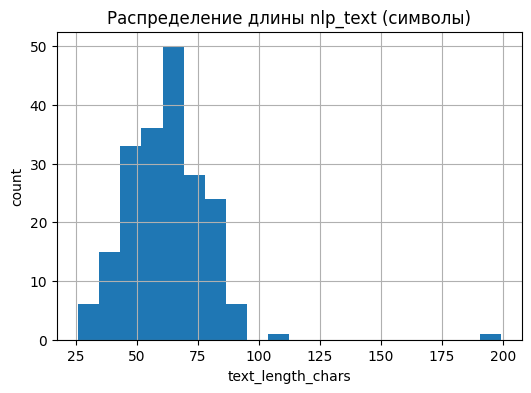

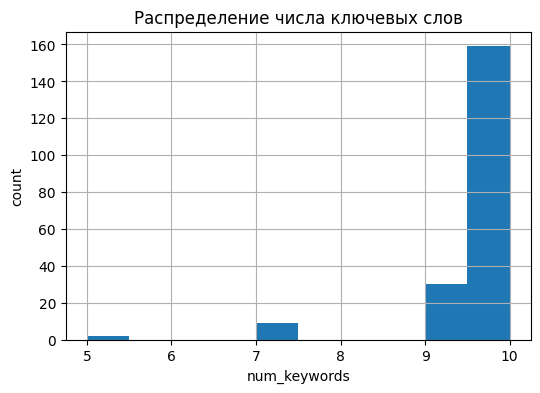

In [30]:
# Гистограмма длины текста
plt.figure(figsize=(6, 4))
df["text_length_chars"].hist(bins=20)
plt.title("Распределение длины nlp_text (символы)")
plt.xlabel("text_length_chars")
plt.ylabel("count")
plt.show()

# Гистограмма числа ключевых слов
plt.figure(figsize=(6, 4))
df["num_keywords"].hist(bins=10)
plt.title("Распределение числа ключевых слов")
plt.xlabel("num_keywords")
plt.ylabel("count")
plt.show()

## 4. Анализ ключевых слов для одного дня

Разберем, какие ключевые слова чаще всего встречаются в заголовках за этот день.
Для этого переведем колонку `keywords` из строки в список и развернем (explode) в "длинный" формат.

In [31]:
# Вспомогательная функция для перевода строки "kw1; kw2; ..." в список
def split_keywords(s: str) -> list[str]:
    if not isinstance(s, str) or not s.strip():
        return []
    return [kw.strip() for kw in s.split(";") if kw.strip()]

# Применяем к выбранному дню
df["keywords_list"] = df["keywords"].apply(split_keywords)
df[["title", "keywords", "keywords_list"]].head(5)

,title,keywords,keywords_list
0,В Европе назвали условие отказа Украины от территорий,назвали условие; территорий; условие; условие отказа; украины территорий; европе назвали; отказа украины; европе; украины; отказа,"[назвали условие, территорий, условие, условие отказа, украины территорий, европе назвали, отказа украины, европе, украины, отказа]"
1,Украина бросила в бой редкую и бесполезную технику в зоне СВО,бой; бой редкую; бросила бой; бесполезную; бесполезную технику; редкую бесполезную; редкую; бросила; украина; зоне сво,"[бой, бой редкую, бросила бой, бесполезную, бесполезную технику, редкую бесполезную, редкую, бросила, украина, зоне сво]"
2,Зеленский поручил разведке отслеживать сотрудничество России с одной страной,поручил; страной; разведке; разведке отслеживать; сотрудничество; сотрудничество россии; зеленский; зеленский поручил; россии одной; отслеживать,"[поручил, страной, разведке, разведке отслеживать, сотрудничество, сотрудничество россии, зеленский, зеленский поручил, россии одной, отслеживать]"
3,Утопившей новорожденного сына в тазу россиянке избрали меру пресечения,тазу; утопившей новорожденного; новорожденного сына; новорожденного; россиянке избрали; избрали меру; избрали; тазу россиянке; утопившей; сына тазу,"[тазу, утопившей новорожденного, новорожденного сына, новорожденного, россиянке избрали, избрали меру, избрали, тазу россиянке, утопившей, сына тазу]"
4,В России рассказали об ответе на ввод войск стран Европы на Украину,россии рассказали; ответе; ввод войск; украину; европы; европы украину; войск стран; рассказали ответе; ответе ввод; ввод,"[россии рассказали, ответе, ввод войск, украину, европы, европы украину, войск стран, рассказали ответе, ответе ввод, ввод]"


In [32]:
# Разворачиваем keywords_list в отдельные строки
kw_exploded = df.explode("keywords_list", ignore_index=True)
kw_exploded = kw_exploded[kw_exploded["keywords_list"].notna() & (kw_exploded["keywords_list"] != "")]
kw_exploded.head(5)

,id,title,link,published_at,source,raw_text,clean_text,nlp_text,summary,keywords,text_length_chars,num_sentences,num_keywords,keywords_list
0,https://lenta.ru/news/2025/12/10/v-evrope-nazvali-uslovie-otkaza-ukrainy-ot-territoriy/,В Европе назвали условие отказа Украины от территорий,https://lenta.ru/news/2025/12/10/v-evrope-nazvali-uslovie-otkaza-ukrainy-ot-territoriy/,2025-12-10 15:54:26+03:00,lenta.ru,,,В Европе назвали условие отказа Украины от территорий,В Европе назвали условие отказа Украины от территорий,назвали условие; территорий; условие; условие отказа; украины территорий; европе назвали; отказа украины; европе; украины; отказа,53,1,10,назвали условие
1,https://lenta.ru/news/2025/12/10/v-evrope-nazvali-uslovie-otkaza-ukrainy-ot-territoriy/,В Европе назвали условие отказа Украины от территорий,https://lenta.ru/news/2025/12/10/v-evrope-nazvali-uslovie-otkaza-ukrainy-ot-territoriy/,2025-12-10 15:54:26+03:00,lenta.ru,,,В Европе назвали условие отказа Украины от территорий,В Европе назвали условие отказа Украины от территорий,назвали условие; территорий; условие; условие отказа; украины территорий; европе назвали; отказа украины; европе; украины; отказа,53,1,10,территорий
2,https://lenta.ru/news/2025/12/10/v-evrope-nazvali-uslovie-otkaza-ukrainy-ot-territoriy/,В Европе назвали условие отказа Украины от территорий,https://lenta.ru/news/2025/12/10/v-evrope-nazvali-uslovie-otkaza-ukrainy-ot-territoriy/,2025-12-10 15:54:26+03:00,lenta.ru,,,В Европе назвали условие отказа Украины от территорий,В Европе назвали условие отказа Украины от территорий,назвали условие; территорий; условие; условие отказа; украины территорий; европе назвали; отказа украины; европе; украины; отказа,53,1,10,условие
3,https://lenta.ru/news/2025/12/10/v-evrope-nazvali-uslovie-otkaza-ukrainy-ot-territoriy/,В Европе назвали условие отказа Украины от территорий,https://lenta.ru/news/2025/12/10/v-evrope-nazvali-uslovie-otkaza-ukrainy-ot-territoriy/,2025-12-10 15:54:26+03:00,lenta.ru,,,В Европе назвали условие отказа Украины от территорий,В Европе назвали условие отказа Украины от территорий,назвали условие; территорий; условие; условие отказа; украины территорий; европе назвали; отказа украины; европе; украины; отказа,53,1,10,условие отказа
4,https://lenta.ru/news/2025/12/10/v-evrope-nazvali-uslovie-otkaza-ukrainy-ot-territoriy/,В Европе назвали условие отказа Украины от территорий,https://lenta.ru/news/2025/12/10/v-evrope-nazvali-uslovie-otkaza-ukrainy-ot-territoriy/,2025-12-10 15:54:26+03:00,lenta.ru,,,В Европе назвали условие отказа Украины от территорий,В Европе назвали условие отказа Украины от территорий,назвали условие; территорий; условие; условие отказа; украины территорий; европе назвали; отказа украины; европе; украины; отказа,53,1,10,украины территорий


In [33]:
# Топ-ключевые слова за этот день
top_kw = kw_exploded["keywords_list"].value_counts().head(30)
top_kw

keywords_list
слова                        5
зеленского энергетическом    4
энергетическом перемирии     4
россиянам                    4
зеленского                   3
перемирии                    3
энергетическом               3
кремле                       3
слова зеленского             3
слов                         2
неожиданная                  2
указал                       2
составлен                    2
рейтинг самых                2
судного                      2
рейтинг                      2
передала                     2
стран 2025                   2
рассказали                   2
2025 года                    2
радиостанция                 2
2025                         2
украине                      2
оценили                      2
россии оценили               2
сво                          2
максимума                    2
радиостанция судного         2
армия                        2
2026 году                    2
Name: count, dtype: int64

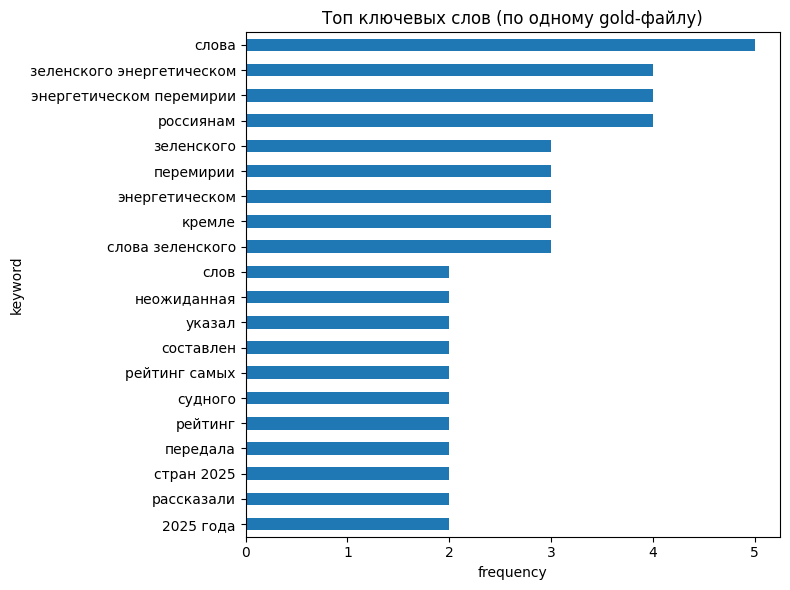

In [34]:
# Визуализация топ-20 ключевых слов
plt.figure(figsize=(8, 6))
top_kw.head(20)[::-1].plot(kind="barh")
plt.title("Топ ключевых слов (по одному gold-файлу)")
plt.xlabel("frequency")
plt.ylabel("keyword")
plt.tight_layout()
plt.show()

## 5. Анализ нескольких gold-файлов и динамика ключевых слов по дням

Теперь объединим несколько gold-файлов в один DataFrame, добавим колонку с датой файла
и посмотрим, как меняются ключевые слова от дня к дню.

In [35]:
# Функция для извлечения даты (YYYYMMDD) из имени файла
def extract_date_from_filename(path: pathlib.Path):
    """
    Пытается вытащить дату формата YYYYMMDD из имени файла.
    Например: articles_20251210_155554_processed.parquet -> 2025-12-10
    """
    m = re.search(r"(\d{8})", path.name)
    if not m:
        return None
    s = m.group(1)
    return datetime.strptime(s, "%Y%m%d").date()

# Собираем все gold-файлы в один DataFrame
dfs = []

for path in gold_files:
    file_date = extract_date_from_filename(path)
    print(f"Загружаем {path.name}, date={file_date}")
    
    df_part = pd.read_parquet(path)
    df_part["file_date"] = file_date
    df_part["keywords_list"] = df_part["keywords"].apply(split_keywords)
    dfs.append(df_part)

df_all = pd.concat(dfs, ignore_index=True)
df_all.shape, df_all.columns

Загружаем articles_20251210_155554_processed.parquet, date=2025-12-10


((200, 15),
 Index(['id', 'title', 'link', 'published_at', 'source', 'raw_text',
        'clean_text', 'nlp_text', 'summary', 'keywords', 'text_length_chars',
        'num_sentences', 'num_keywords', 'file_date', 'keywords_list'],
       dtype='object'))

In [36]:
# Количество статей по дням
df_all["file_date"].value_counts().sort_index()

file_date
2025-12-10    200
Name: count, dtype: int64

In [38]:
# Простая сводка по дням: сколько статей, средняя длина текста и количество keywords
df_all.groupby("file_date").agg(
    n_articles=("id", "count"),
    avg_len=("text_length_chars", "mean"),
    avg_num_keywords=("num_keywords", "mean"),
)

,n_articles,avg_len,avg_num_keywords
file_date,,,
2025-12-10,200,62.215,9.665


In [39]:
# Разворачиваем keywords_list по всем дням
kw_all = df_all.explode("keywords_list", ignore_index=True)
kw_all = kw_all[kw_all["keywords_list"].notna() & (kw_all["keywords_list"] != "")]
kw_all.head(5)

,id,title,link,published_at,source,raw_text,clean_text,nlp_text,summary,keywords,text_length_chars,num_sentences,num_keywords,file_date,keywords_list
0,https://lenta.ru/news/2025/12/10/v-evrope-nazvali-uslovie-otkaza-ukrainy-ot-territoriy/,В Европе назвали условие отказа Украины от территорий,https://lenta.ru/news/2025/12/10/v-evrope-nazvali-uslovie-otkaza-ukrainy-ot-territoriy/,2025-12-10 15:54:26+03:00,lenta.ru,,,В Европе назвали условие отказа Украины от территорий,В Европе назвали условие отказа Украины от территорий,назвали условие; территорий; условие; условие отказа; украины территорий; европе назвали; отказа украины; европе; украины; отказа,53,1,10,2025-12-10,назвали условие
1,https://lenta.ru/news/2025/12/10/v-evrope-nazvali-uslovie-otkaza-ukrainy-ot-territoriy/,В Европе назвали условие отказа Украины от территорий,https://lenta.ru/news/2025/12/10/v-evrope-nazvali-uslovie-otkaza-ukrainy-ot-territoriy/,2025-12-10 15:54:26+03:00,lenta.ru,,,В Европе назвали условие отказа Украины от территорий,В Европе назвали условие отказа Украины от территорий,назвали условие; территорий; условие; условие отказа; украины территорий; европе назвали; отказа украины; европе; украины; отказа,53,1,10,2025-12-10,территорий
2,https://lenta.ru/news/2025/12/10/v-evrope-nazvali-uslovie-otkaza-ukrainy-ot-territoriy/,В Европе назвали условие отказа Украины от территорий,https://lenta.ru/news/2025/12/10/v-evrope-nazvali-uslovie-otkaza-ukrainy-ot-territoriy/,2025-12-10 15:54:26+03:00,lenta.ru,,,В Европе назвали условие отказа Украины от территорий,В Европе назвали условие отказа Украины от территорий,назвали условие; территорий; условие; условие отказа; украины территорий; европе назвали; отказа украины; европе; украины; отказа,53,1,10,2025-12-10,условие
3,https://lenta.ru/news/2025/12/10/v-evrope-nazvali-uslovie-otkaza-ukrainy-ot-territoriy/,В Европе назвали условие отказа Украины от территорий,https://lenta.ru/news/2025/12/10/v-evrope-nazvali-uslovie-otkaza-ukrainy-ot-territoriy/,2025-12-10 15:54:26+03:00,lenta.ru,,,В Европе назвали условие отказа Украины от территорий,В Европе назвали условие отказа Украины от территорий,назвали условие; территорий; условие; условие отказа; украины территорий; европе назвали; отказа украины; европе; украины; отказа,53,1,10,2025-12-10,условие отказа
4,https://lenta.ru/news/2025/12/10/v-evrope-nazvali-uslovie-otkaza-ukrainy-ot-territoriy/,В Европе назвали условие отказа Украины от территорий,https://lenta.ru/news/2025/12/10/v-evrope-nazvali-uslovie-otkaza-ukrainy-ot-territoriy/,2025-12-10 15:54:26+03:00,lenta.ru,,,В Европе назвали условие отказа Украины от территорий,В Европе назвали условие отказа Украины от территорий,назвали условие; территорий; условие; условие отказа; украины территорий; европе назвали; отказа украины; европе; украины; отказа,53,1,10,2025-12-10,украины территорий


In [40]:
top_kw_all = kw_all["keywords_list"].value_counts().head(30)
top_kw_all

keywords_list
слова                        5
зеленского энергетическом    4
энергетическом перемирии     4
россиянам                    4
зеленского                   3
перемирии                    3
энергетическом               3
кремле                       3
слова зеленского             3
слов                         2
неожиданная                  2
указал                       2
составлен                    2
рейтинг самых                2
судного                      2
рейтинг                      2
передала                     2
стран 2025                   2
рассказали                   2
2025 года                    2
радиостанция                 2
2025                         2
украине                      2
оценили                      2
россии оценили               2
сво                          2
максимума                    2
радиостанция судного         2
армия                        2
2026 году                    2
Name: count, dtype: int64

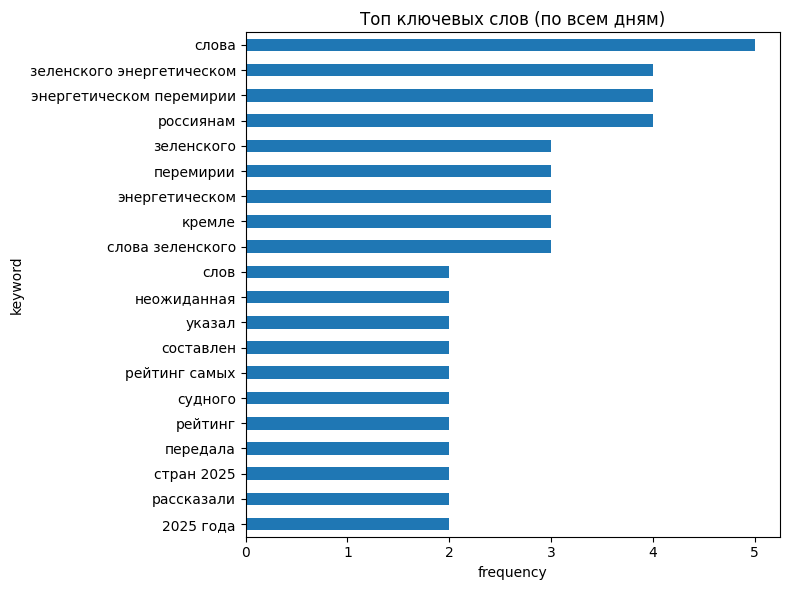

In [41]:
plt.figure(figsize=(8, 6))
top_kw_all.head(20)[::-1].plot(kind="barh")
plt.title("Топ ключевых слов (по всем дням)")
plt.xlabel("frequency")
plt.ylabel("keyword")
plt.tight_layout()
plt.show()

In [42]:
# Частоты ключевых слов по дням
kw_by_day = (
    kw_all
    .groupby(["file_date", "keywords_list"])
    .size()
    .reset_index(name="cnt")
)

# Берем глобальный топ-15 ключевых слов
top15_global = kw_all["keywords_list"].value_counts().head(15).index

kw_top15_by_day = kw_by_day[kw_by_day["keywords_list"].isin(top15_global)]

# Строим сводную таблицу: строки — дни, столбцы — ключевые слова
pivot_kw = kw_top15_by_day.pivot_table(
    index="file_date",
    columns="keywords_list",
    values="cnt",
    aggfunc="sum",
    fill_value=0,
)

pivot_kw

keywords_list,зеленского,зеленского энергетическом,кремле,неожиданная,перемирии,рейтинг самых,россиянам,слов,слова,слова зеленского,составлен,судного,указал,энергетическом,энергетическом перемирии
file_date,,,,,,,,,,,,,,,
2025-12-10,3,4,3,2,3,2,4,2,5,3,2,2,2,3,4


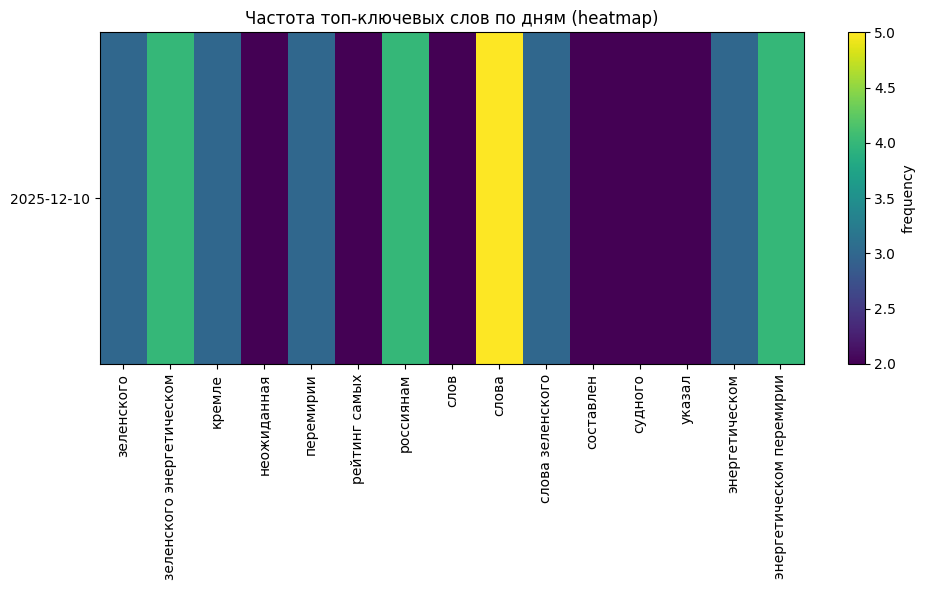

In [43]:
# Визуализация: heatmap частот ключевых слов по дням
plt.figure(figsize=(10, 6))

plt.imshow(pivot_kw.values, aspect="auto")
plt.colorbar(label="frequency")

plt.xticks(
    ticks=range(len(pivot_kw.columns)),
    labels=pivot_kw.columns,
    rotation=90
)
plt.yticks(
    ticks=range(len(pivot_kw.index)),
    labels=pivot_kw.index
)

plt.title("Частота топ-ключевых слов по дням (heatmap)")
plt.tight_layout()
plt.show()

In [22]:
df_all[
    ["file_date", "source", "title", "keywords"]
].sort_values(["file_date"]).head(20)

,file_date,source,title,keywords
0,2025-12-10,lenta.ru,В Европе назвали условие отказа Украины от территорий,назвали условие; территорий; условие; условие отказа; украины территорий; европе назвали; отказа украины; европе; украины; отказа
127,2025-12-10,lenta.ru,Назван фаворит матча Лиги чемпионов между «Реалом» и «Манчестер Сити»,манчестер сити; матча лиги; фаворит; манчестер; сити; чемпионов реалом; чемпионов; реалом манчестер; реалом; матча
128,2025-12-10,lenta.ru,Потребление популярных напитков связали с повышенным риском инсульта,потребление; риском инсульта; потребление популярных; популярных напитков; популярных; повышенным риском; повышенным; напитков; связали повышенным; связали
129,2025-12-10,lenta.ru,СМИ узнали о новых деталях мирного соглашения по Украине,узнали; деталях мирного; соглашения; соглашения украине; сми узнали; новых деталях; сми; мирного; деталях; мирного соглашения
130,2025-12-10,lenta.ru,ЦБ указал на серьезное долговое бремя россиян,серьезное; долговое бремя; бремя россиян; бремя; указал серьезное; серьезное долговое; долговое; указал; россиян
131,2025-12-10,lenta.ru,Командирам ВСУ вынесли приговор за приказ атаковать дронами пляж российского города,пляж; приказ атаковать; приговор приказ; приговор; вынесли; вынесли приговор; командирам; приказ; командирам всу; пляж российского
132,2025-12-10,lenta.ru,Путин посетит нейтральную постсоветскую страну,постсоветскую страну; путин посетит; нейтральную постсоветскую; нейтральную; посетит нейтральную; посетит; постсоветскую; путин; страну
133,2025-12-10,lenta.ru,Россиянка вернулась из отпуска с заспиртованной коброй и заинтересовала таможню,таможню; вернулась отпуска; россиянка вернулась; заинтересовала; заинтересовала таможню; отпуска; заспиртованной; заспиртованной коброй; коброй заинтересовала; отпуска заспиртованной
134,2025-12-10,lenta.ru,В Латинской Америке произошло мощное землетрясение,мощное землетрясение; латинской; америке; америке произошло; латинской америке; произошло; произошло мощное; мощное; землетрясение
135,2025-12-10,lenta.ru,Избитая российская инста-модель назвала имя обидчика,имя; обидчика; имя обидчика; российская инста; избитая российская; избитая; модель назвала; назвала имя; инста; инста модель


## 6. Выводы и идеи для развития

В рамках этого ноутбука мы:

- Проверили структуру и базовые статистики gold-слоя (semantic layer).
- Убедились, что `nlp_text`, `summary` и `keywords` заполнены и выглядят осмысленно.
- Посмотрели распределения длины текста и числа ключевых слов.
- Получили топ ключевых слов как по отдельному дню, так и по нескольким дням сразу.
- Построили простую динамику ключевых слов по дням (heatmap).

Возможные дальнейшие шаги:

- Расширить набор стоп-слов и улучшить лемматизацию для русских текстов.
- Добавить в анализ полный текст новости (когда появится парсер body статей).
- Перенести аналогичный анализ в ClickHouse и BI-инструменты (Superset, DataLens).
- Построить агрегированные витрины по темам, источникам и периоду времени.